In [4]:
using Plots
using SparseArrays
using LinearAlgebra

# Exercise 2

## Task 2 

In [122]:
function create_sheme(name::String,c::Float64,N::Int64)
    
    if name == "FTBS"
        M = sparse(1:N,1:N,1-c)
        M += spdiagm(-1=>c*ones(N-1))
        M[1,N-1] = c
        
    elseif name == "CTCS"
        M = sparse(1:N,1:N,0)
        M += spdiagm(1=>-c*ones(N-1))
        M += spdiagm(-1=>c*ones(N-1))
        M[1,N] = c
        M[N,1] = -c
        
    elseif name == "FTCS"
        c /= 2        
        M = sparse(1:N,1:N,1)
        M += spdiagm(1=>-c*ones(N-1))
        M += spdiagm(-1=>c*ones(N-1))
        M[1,N] = c
        M[N,1] = -c
    end
    
    return M
end

create_sheme (generic function with 1 method)

In [142]:
#we want to code the CTCS sheme (stable for c² <= 1)

#for practice we start with the FTBS sheme

#input : time t(=T), Anfangsbedingung f(t=0), x Interval [a,b]

#output : f(t=T,x)

function simulate(T::Float64,u::typeof(ϕ0),Iₓ::Vector{Float64},Nₓ::Int64,c::Float64,name::String) 
    
    #discretization(stable for c<1)
    Δx = (Iₓ[2]-Iₓ[1])/Nₓ
    Δt = Δx * c #choice to be stable
    Nₜ = Int(T/Δt)

    
    xᵢ = LinRange(Iₓ[1],Iₓ[2],Nₓ)
    tᵢ = LinRange(0,T,Nₜ)
    
    #discretize the starting position
    u₀ = u.(xᵢ)
    
    #create matrix with stores the result  
    M = zeros(Nₜ,Nₓ)
    M[1,:] = u₀[:]
    
    #sheme matrix
    sheme = create_sheme(name,c,Nₓ)
    
    #make N time steps
    if name == "FTBS"
        for n in 1:Nₜ-1
            M[n+1,:] = sheme*M[n,:]
        end
        
    elseif name == "CTCS"
        M[2,:] = create_sheme("FTCS",c,Nₓ)*M[1,:]
        for n in 2:Nₜ-1
            M[n+1,:] = M[n-1,:] + sheme*M[n,:]
        end
    end
    return M
end

simulate (generic function with 1 method)

In [143]:
#exact solution
σ = 0.07
μ = 0.5
ϕ0(x) = exp(-(x-μ)^2 / (2*σ^2))


ϕ0 (generic function with 1 method)

In [149]:
f(x) = x
T = 2.0
c = 0.5
Iₓ = [0.0,1.0]
Nₓ = 50
Δx = (Iₓ[2]-Iₓ[1])/Nₓ
Δt = Δx * c

sol = simulate(T,ϕ0,Iₓ,Nₓ,c,"FTBS")
sol2 = simulate(T,ϕ0,Iₓ,Nₓ,c,"CTCS")

x = LinRange(0,1,Nₓ)
Nₜ = size(sol,1)
println(Nₜ)
plot(x,sol[end-1,:],label = "FTBS",linewidth = 4)
plot!(x,sol2[end-1,:],label = "CTCS",linewidth = 4)
plot!(title = "solution at T = $T")

LoadError: MethodError: no method matching simulate(::Float64, ::typeof(f), ::Vector{Float64}, ::Int64, ::Float64, ::String)
[0mClosest candidates are:
[0m  simulate(::Float64, [91m::typeof(ϕ0)[39m, ::Vector{Float64}, ::Int64, ::Float64, ::String) at In[142]:9

┌ Info: Saved animation to 
│   fn = /Users/Paul/Desktop/Comp. Phys./Exercises/FTBS.gif
└ @ Plots /Users/Paul/.julia/packages/Plots/CBYO0/src/animation.jl:114


Plots.AnimatedGif("/Users/Paul/Desktop/Comp. Phys./Exercises/FTBS.gif")
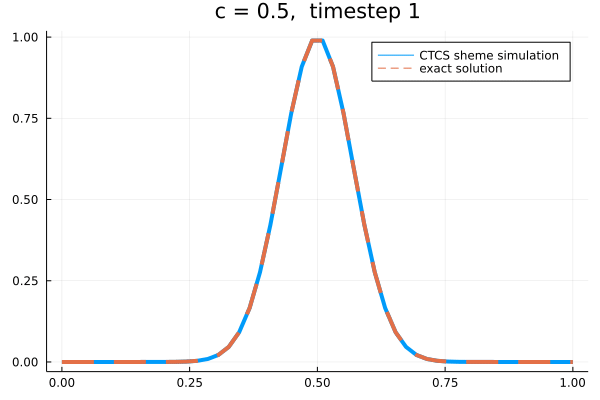

In [148]:

#animate the time steps:
mygif = @animate for s in 1:Nₜ
    #plot(x,sol[s,:],label = "FTBS sheme simulation",linewidth = 4)
    plot(x,sol2[s,:],label = "CTCS sheme simulation",linewidth = 4)
    plot!(x,ϕ0.(mod.(x.-Δt*(s-1), 1)), label = "exact solution",linestyle = :dash, linewidth = 4)
    plot!(title = "c = $c,  timestep $s")
end

gif(mygif, "FTBS.gif", fps = 20)



# Exercise 3

## Task 1

In [5]:
#we want to solve Ax = b
#we can directly write A ans b

#transforms matrix into vector(usefull for getting b)
function m_to_v(M::Matrix,N::Integer)
    v = zeros(N^2)
    for i in 1:N
        v[((i-1)*N+1):i*N] = M[i,:]
    end
    return v
end

#tranform vector into matrix(usefull to plot u(x,y) from x)
function v_to_m(v::Vector,N::Integer)
    M = zeros(N,N)
    for i in 1:N
        M[i,:] = v[((i-1)*N+1):i*N]
    end
    return M
end


v_to_m (generic function with 1 method)

In [20]:
I = [-1,1]
N = 40 #number of points in x and y
N² = N^2
h = (I[2]-I[1])/N # = Δx = Δy

xs = LinRange(-1,1,N)


#boundary condition
M = ones(N,N)
#M[1,:] .= 0
#M[end,:] .= 0
#M[:,1] .= 0
#M[:,end] .= 0

#create Matrix A
A = sparse(1:N²,1:N²,-4)
A += spdiagm(1=>ones(N²-1))      
A += spdiagm(-1=>ones(N²-1))   
A += spdiagm(N+1=>ones(N²-N-1))      
A += spdiagm(-N-1=>ones(N²-N-1))  

#create vector b
b = -1*h^2*m_to_v(M,N)

#Boundary conditions
for i in 1:N-1
    A[i*N,:] .= 0
    A[i*N,i*N] = 1
    A[i*N+1,:] .= 0
    A[i*N+1,i*N+1] = 1
    A[i,:] .= 0
    A[i,i] = 1
    A[N^2-i+1,:] .= 0
    A[N^2-i+1,N^2-i+1] = 1
end

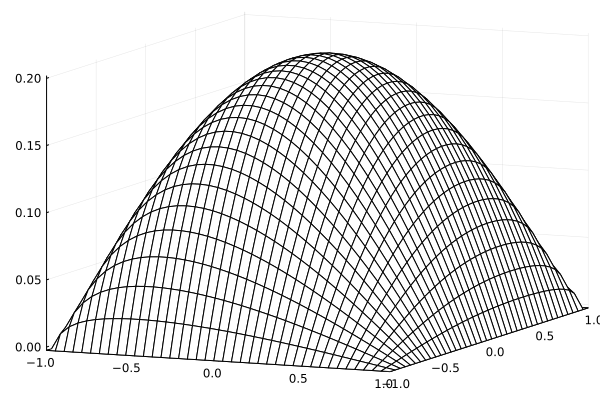

In [21]:
X = A\b
U = v_to_m(X,N)
wireframe(xs,xs,U)